# fvGP Single-Task Test

In [2]:
#!pip install fvgp~=4.6.4

## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

In [4]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

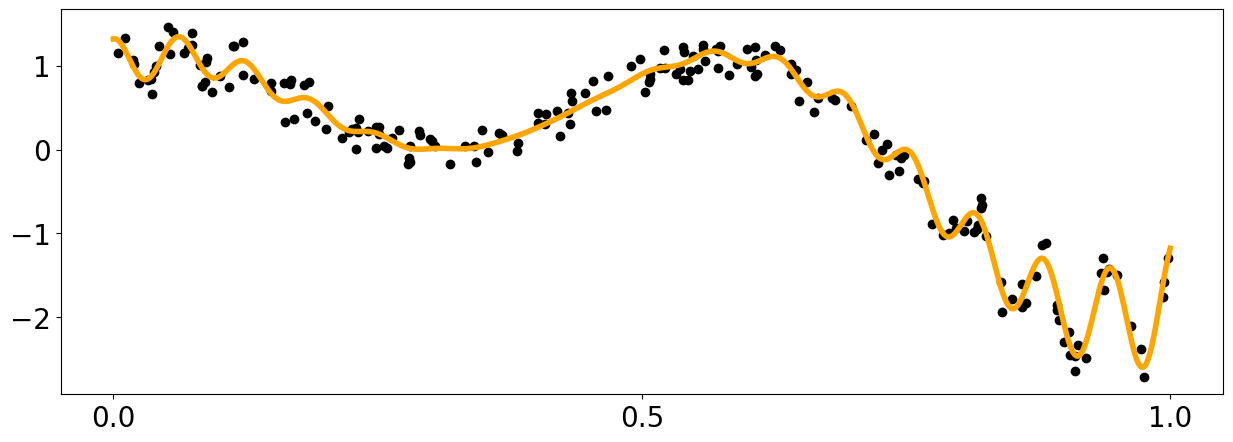

In [5]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(200).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing a Gaussian Process

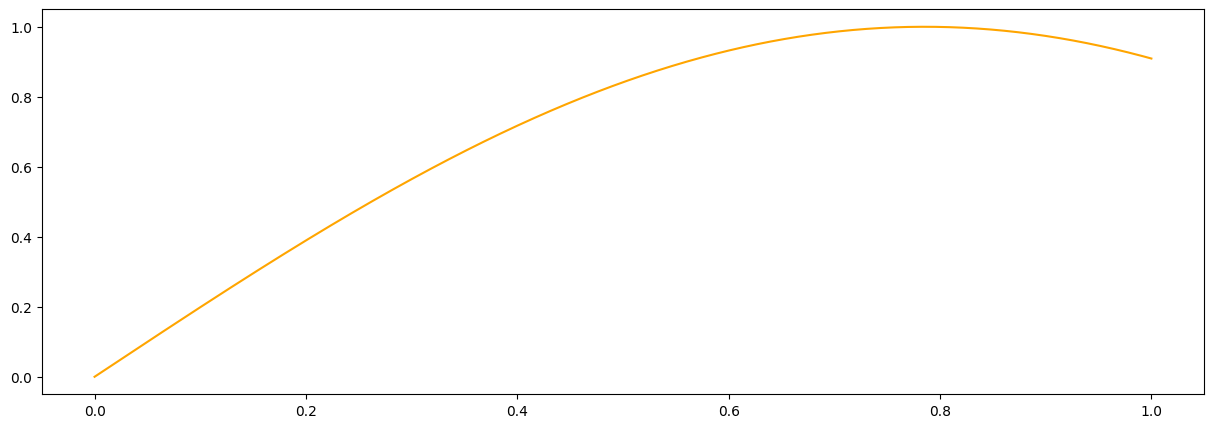

In [6]:
from fvgp.kernels import *
from scipy import sparse
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise can be a vector, a matrix, or a sparse matrix in case gp2Scale is used.  
    return np.zeros(len(x)) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and different training options

In [35]:


my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])
my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.05) #this is just for testing, not needed
print("Standard Training (MCMC)")
my_gp1.train(hyperparameter_bounds=hps_bounds, info = True)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("HGDL Training")
print(my_gp1.get_hyperparameters())
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10, dask_client=client)


Standard Training (MCMC)
Finished  10  out of  200  MCMC iterations. f(x)=  -53.631849443019235
Finished  20  out of  200  MCMC iterations. f(x)=  -37.823871497890934
Finished  30  out of  200  MCMC iterations. f(x)=  -24.82076191462727
Finished  40  out of  200  MCMC iterations. f(x)=  -24.82076191462727
Finished  50  out of  200  MCMC iterations. f(x)=  5.348705042502445
Finished  60  out of  200  MCMC iterations. f(x)=  5.348705042502445
Finished  70  out of  200  MCMC iterations. f(x)=  7.043267766596159
Finished  80  out of  200  MCMC iterations. f(x)=  7.043267766596159
Finished  90  out of  200  MCMC iterations. f(x)=  6.709755177422892
Finished  100  out of  200  MCMC iterations. f(x)=  5.23424947819359
Finished  110  out of  200  MCMC iterations. f(x)=  7.045809073492251
Finished  120  out of  200  MCMC iterations. f(x)=  6.629940363131595
Finished  130  out of  200  MCMC iterations. f(x)=  6.869168447601567
Finished  140  out of  200  MCMC iterations. f(x)=  5.847820892142124

array([0.85711076, 0.06057622, 0.0213567 , 0.01      ])

### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [36]:
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds, dask_client=client)

In [37]:
# The result won't change much (or at all) since this is such a simple optimization
for i in range(10):
    time.sleep(0.2)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
    print("")

/home/marcus/Coding/fvGP/fvgp/gp_training.py:149: UserWarning:      Hyperparameter update failed with ERROR: list index out of range
  warnings.warn("     Hyperparameter update failed with ERROR: " + str(err))


[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]

[0.85711076 0.06057622 0.0213567  0.01      ]



In [38]:
my_gp1.stop_training(opt_obj) ##this leaves the dask client alive, kill_client() will shut it down. 

## The Result

RMSE:              0.06673835308973348
CRPS (mean, std):  (np.float64(0.03838585783892384), np.float64(0.024102670327579984))
R2:                0.9958164888103015
NLPD:              -1.1989178160409184


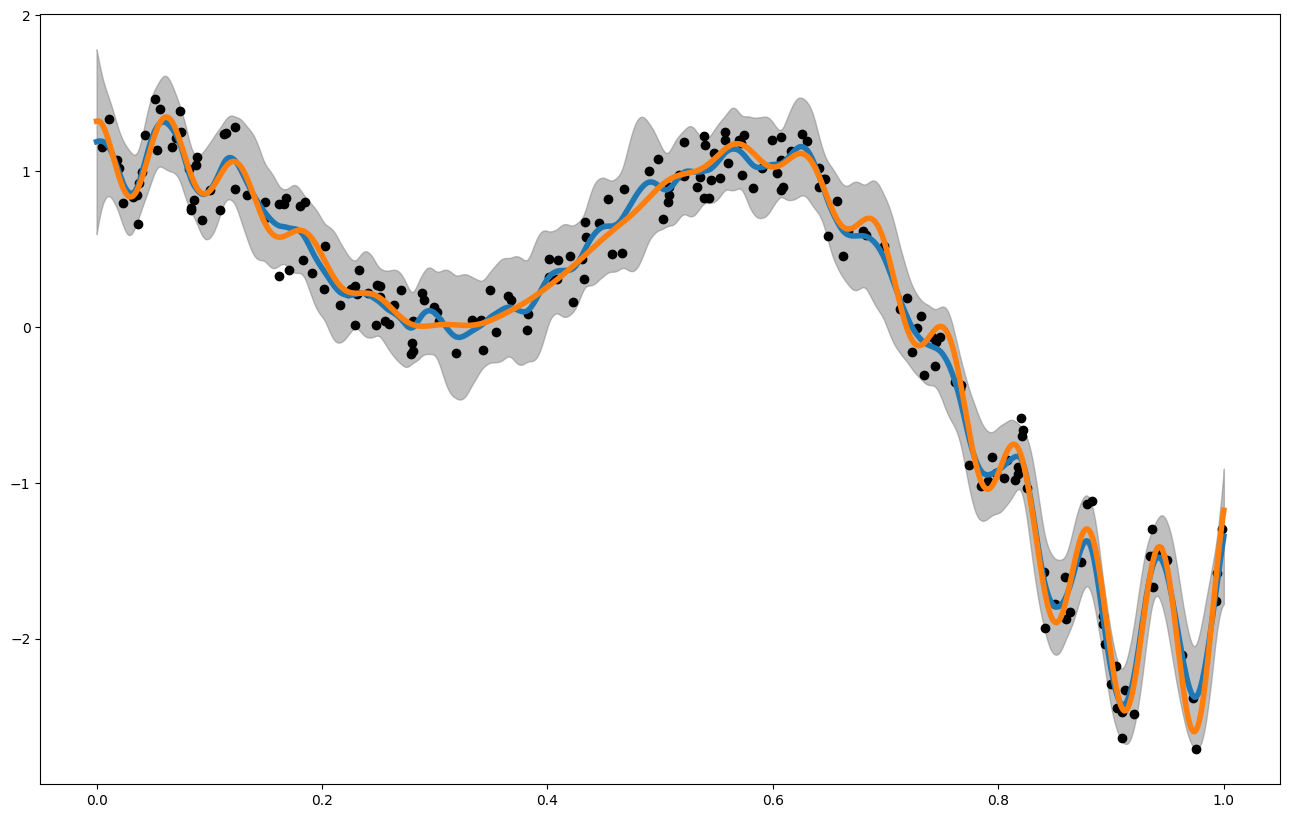

In [68]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)


mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=True, add_noise=False)["v(x)"]

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print("RMSE:             ",my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print("CRPS (mean, std): ",my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))
print("R2:               ",my_gp1.r2(x_pred1D,f1(x_pred1D).flatten()))
print("NLPD:             ",my_gp1.nlpd(x_pred1D,f1(x_pred1D).flatten()))

## Predicted Information Gain

In [42]:
relative_entropy =  my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))["RIE"]

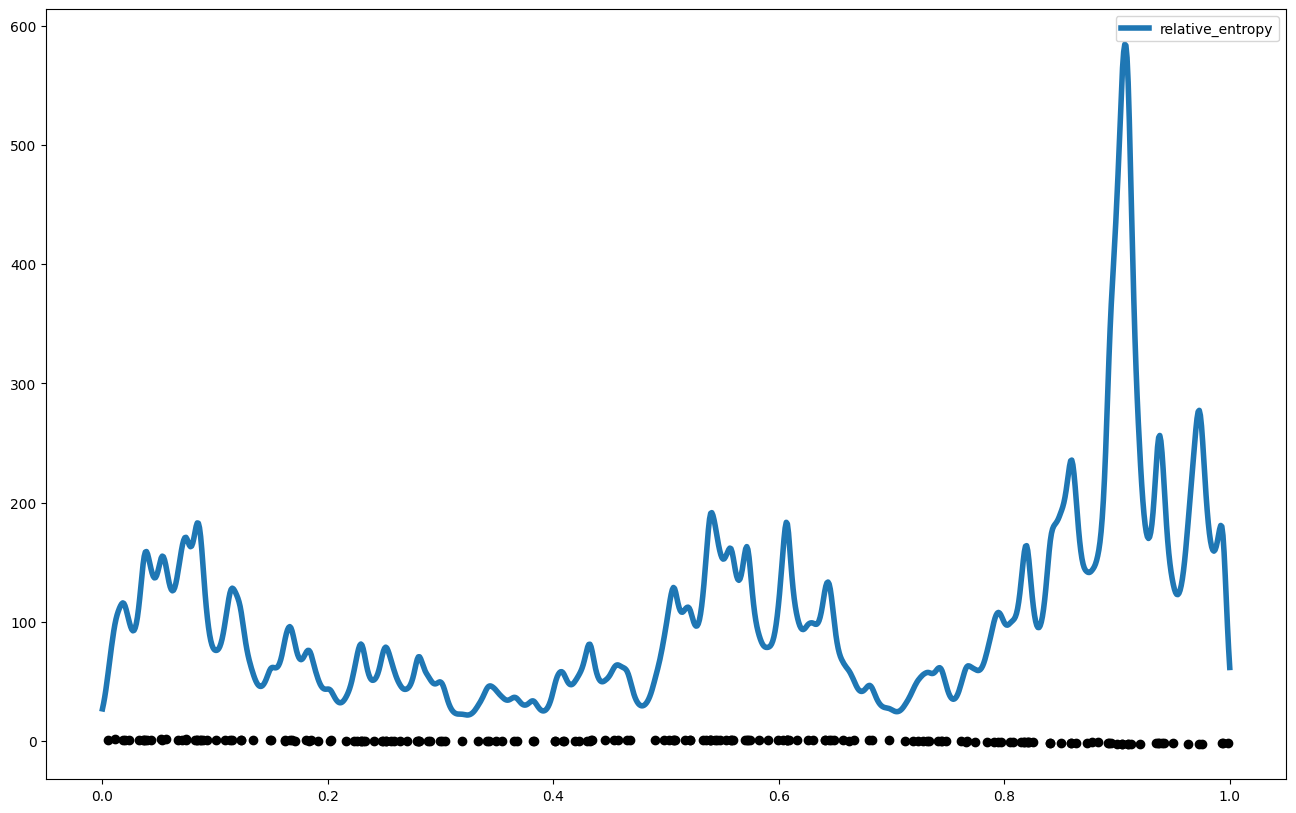

In [43]:
plt.figure(figsize = (16,10))
plt.plot(x_pred,relative_entropy, label = "relative_entropy", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [44]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("MI: ",my_gp1.gp_mutual_information(x_test))
print("TC: ",my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))



MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(3.8387465339887967)}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(13.776711714941456)}


{'mu': array([0.64994671, 0.64994671]),
 'covariance': array([[0.01072009, 0.01071999],
        [0.01071999, 0.01072009]]),
 'probability': np.float64(0.13890905824601635)}